In [1]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

In [2]:
%cd /home/ac3492/project/isca_projects/astr575_final_project/setup3/data/setup3_giant_planet_180_days_360_dt_0_5_omega/run0001
%ls

/gpfs/gibbs/project/yankovsky/ac3492/isca_projects/astr575_final_project/setup3/data/setup3_giant_planet_180_days_360_dt_0_5_omega/run0001
atmos_monthly.nc  diag_table  field_table  git_hash_used.txt  input.nml


In [3]:
ds = xr.open_dataset('atmos_monthly.nc', decode_times=False)
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (lon: 1024, lonb: 1025, lat: 320, latb: 321, time: 6, nv: 2,
                  phalf: 31, pfull: 30)
Coordinates:
  * lon          (lon) float64 8kB 0.0 0.3516 0.7031 1.055 ... 358.9 359.3 359.6
  * lonb         (lonb) float64 8kB -0.1758 0.1758 0.5273 ... 359.1 359.5 359.8
  * lat          (lat) float64 3kB -89.57 -89.01 -88.45 ... 88.45 89.01 89.57
  * latb         (latb) float64 3kB -90.0 -89.31 -88.74 ... 88.74 89.31 90.0
  * time         (time) float64 48B 15.0 45.0 75.0 105.0 135.0 165.0
  * nv           (nv) float64 16B 1.0 2.0
  * phalf        (phalf) float64 248B 0.0 100.0 200.0 ... 2.8e+03 2.9e+03 3e+03
  * pfull        (pfull) float64 240B 36.79 147.2 248.3 ... 2.85e+03 2.95e+03
Data variables:
    ps           (time, lat, lon) float32 8MB ...
    bk           (phalf) float32 124B ...
    pk           (phalf) float32 124B ...
    ucomp        (time, pfull, lat, lon) float32 236MB ...
    vcomp        (time, pfull, lat, lon) float32 236MB ...
    temp         (time, pfull, lat, lon) float32 236MB ...
    vor          (time, pfull, lat, lon) float32 236MB ...
    div          (time, pfull, lat, lon) float32 236MB ...
    average_T1   (time) float64 48B ...
    average_T2   (time) float64 48B ...
    average_DT   (time) float64 48B ...
    time_bounds  (time, nv) float64 96B ...
Attributes:
    filename:   /home/ac3492/project/isca_projects/astr575_final_project/setu...
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

In [4]:
ds.temp  # (time, pfull, lat, lon)
temp_mean = ds.temp.mean(dim="pfull")  # Now temp_mean has shape: (time, lat, lon)

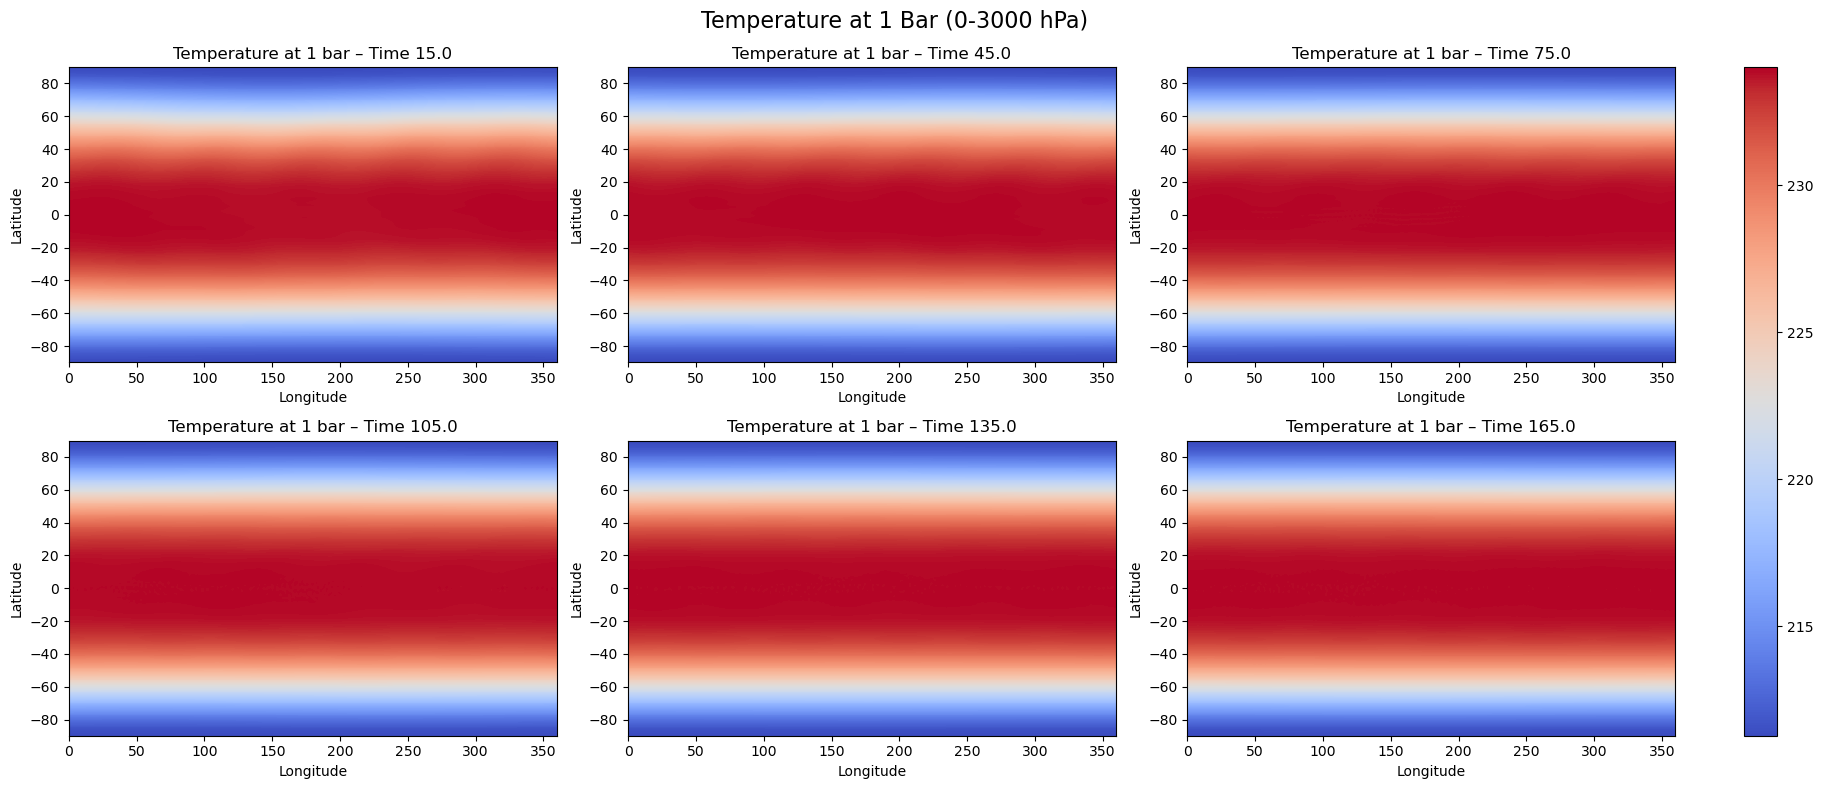

In [5]:
# Find the index where pfull is closest to 1 bar (1000 hPa)
pfull_1bar_index = (abs(ds.pfull - 1000)).argmin()  # index closest to 1 bar

# Select temperature data at 1 bar (1000 hPa) for all time slices, latitudes, and longitudes
temp_1bar = ds.temp[:, pfull_1bar_index, :, :]  # shape: (time, lat, lon)

# Create subplots for each time slice
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

# Loop over the 6 time slices
for i in range(6):
    temp_slice = temp_1bar.isel(time=i)  # select data for this time slice at 1 bar

    # Transpose temp_slice if needed (e.g., (lat, lon) format for plotting)
    temp_plot = temp_slice.transpose('lat', 'lon')

    # Plot temperature at 1 bar for the current time slice
    im = axes[i].pcolormesh(ds.lon, ds.lat, temp_plot, shading='auto', cmap='coolwarm')
    axes[i].set_title(f"Temperature at 1 bar – Time {ds.time.values[i]}")
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")

# Add colorbar and title
fig.suptitle("Temperature at 1 Bar (0-3000 hPa)", fontsize=16)
plt.tight_layout()
plt.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

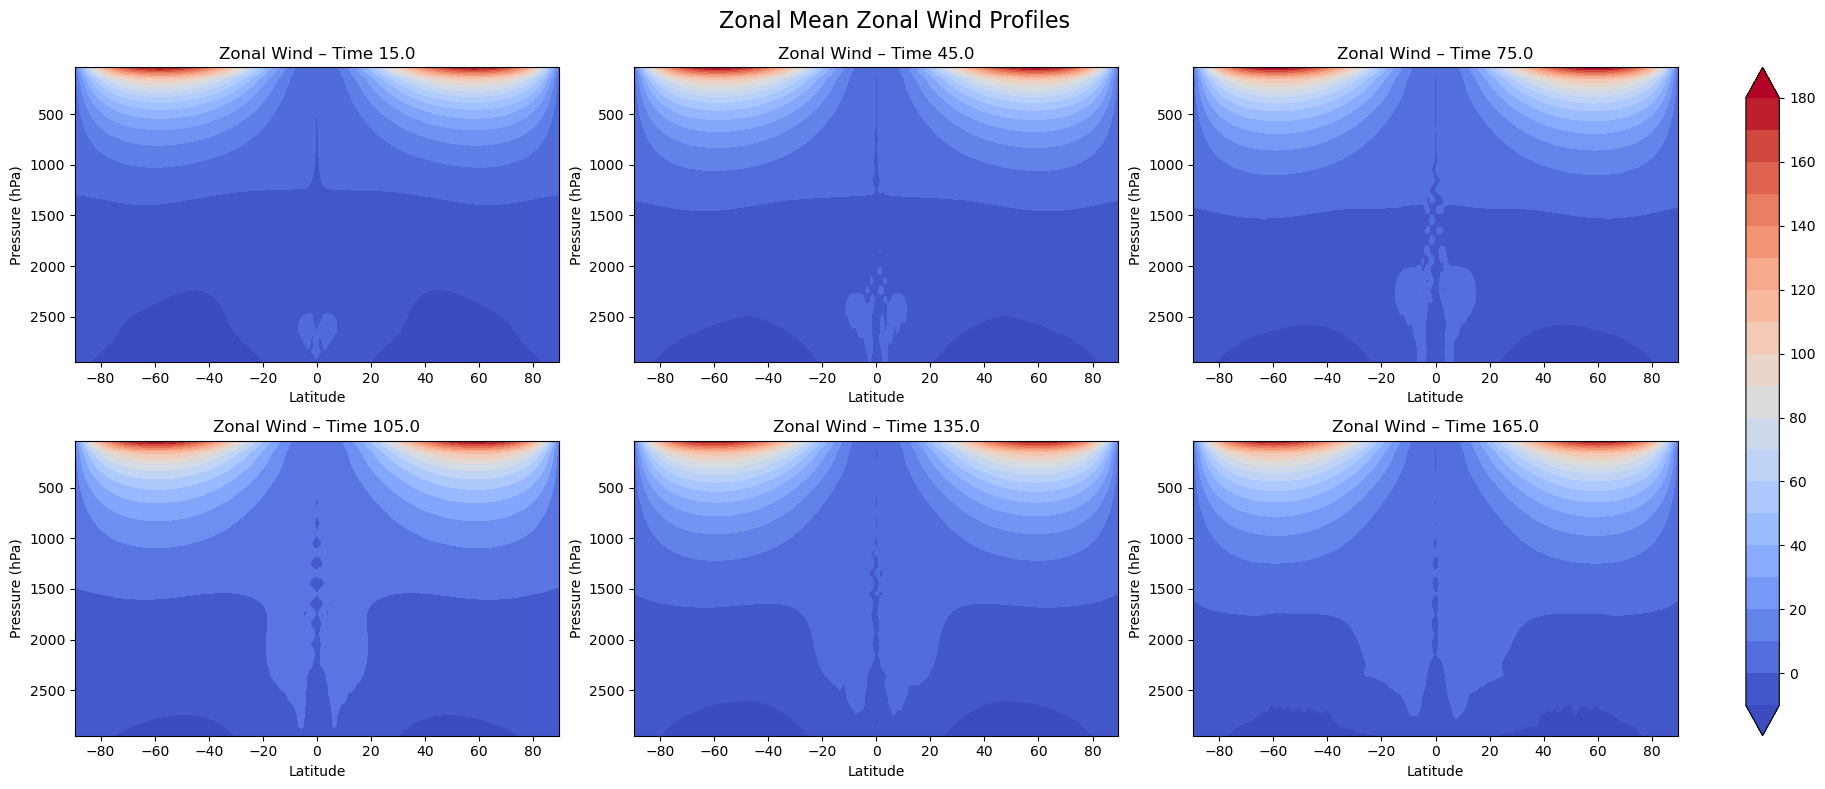

In [6]:
u_zonal_mean = ds.ucomp.mean(dim="lon")  # (time, pfull, lat)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i in range(6):
    u_slice = u_zonal_mean.isel(time=i)  # (pfull, lat)

    # Transpose so axes are (lat, pressure)
    u_plot = u_slice.transpose('pfull', 'lat')  # shape = (30, 320)

    im = axes[i].contourf(ds.lat, ds.pfull, u_plot, levels=21, cmap='coolwarm', extend='both') # Blue (westward winds) at the equator and Red (eastward winds) at mid-latitudes
    axes[i].set_title(f"Zonal Wind – Time {ds.time.values[i]}")
    axes[i].set_xlabel("Latitude")
    axes[i].set_ylabel("Pressure (hPa)")
    axes[i].invert_yaxis()  # Higher pressure at bottom
    axes[i].set_ylim(ds.pfull.max(), ds.pfull.min())

# Add colorbar
fig.suptitle("Zonal Mean Zonal Wind Profiles", fontsize=16)
plt.tight_layout()
plt.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

In [19]:
print(ds.pfull.values)

[  36.78794412  147.15177647  248.31862279  348.80421089  449.07158346
  549.24106263  649.35815034  749.44390839  849.50943584  949.56113994
 1049.60297944 1149.63753264 1249.66655103 1349.69126624 1449.71256961
 1549.73112216 1649.74742448 1749.76186263 1849.77473912 1949.78629434
 2049.79672176 2149.80617884 2249.814795   2349.82267764 2449.82991662
 2549.83658769 2649.84275517 2749.84847399 2849.85379142 2949.85874827]


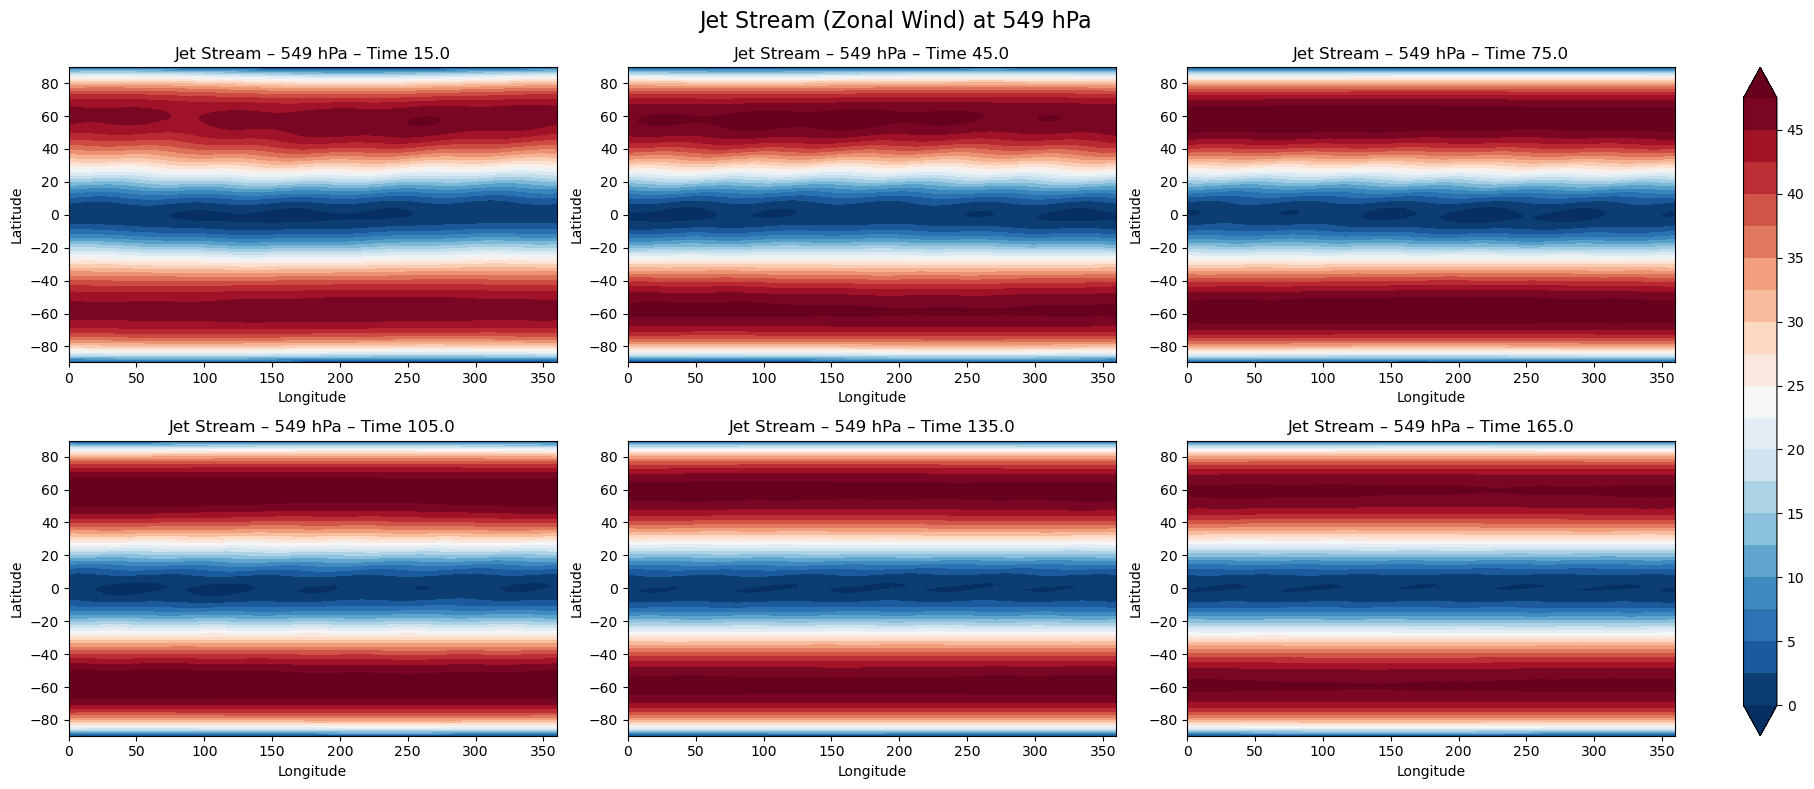

In [7]:
# Choose pressure level index (e.g., closest to 200 hPa)
plev_index = 5
plev_value = ds.pfull.values[plev_index]

# Select zonal wind at that pressure level
u_upper = ds.ucomp.isel(pfull=plev_index)  # shape: (time, lat, lon)

# Plot for each time slice
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i in range(6):
    u_plot = u_upper.isel(time=i)

    im = axes[i].contourf(ds.lon, ds.lat, u_plot, levels=21, cmap='RdBu_r', extend='both')
    axes[i].set_title(f"Jet Stream – {plev_value:.0f} hPa – Time {ds.time.values[i]}")
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")

# Colorbar and layout
fig.suptitle(f"Jet Stream (Zonal Wind) at {plev_value:.0f} hPa", fontsize=16)
plt.tight_layout()
plt.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

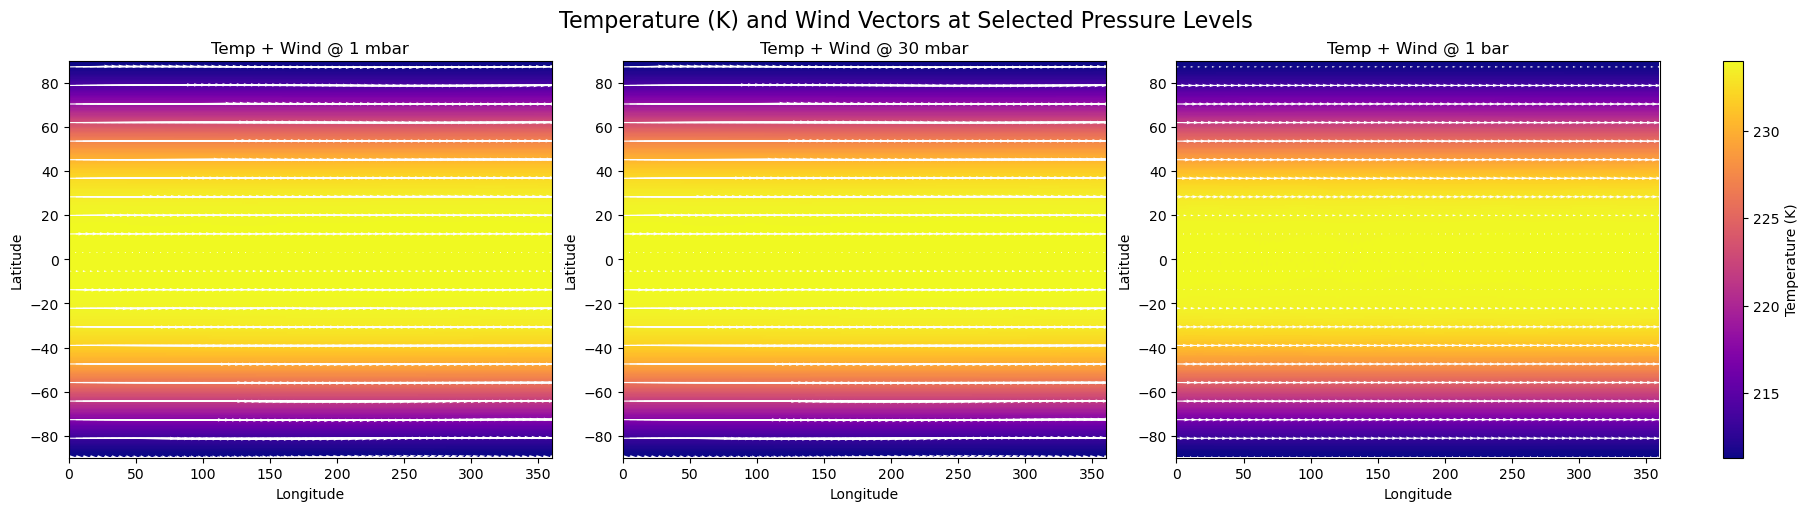

In [8]:

# Convert pressure to mbar (same as hPa)
pfull = ds.pfull  # shape (30,)
pfull_hPa = pfull  # already in hPa, assuming your dataset is in hPa

# Pressure levels (in hPa) to extract
target_pressures = [1, 30, 1000]  # 1 mbar, 30 mbar, 1 bar
labels = ["1 mbar", "30 mbar", "1 bar"]

# Find nearest pressure levels
pressure_indices = [int(np.abs(pfull_hPa - p).argmin()) for p in target_pressures]

# Choose one time slice to show (e.g., last one)
time_index = -1  # or 0, if you prefer early time

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
for ax, p_idx, label in zip(axes, pressure_indices, labels):
    # Extract data
    temp_slice = ds.temp.isel(time=time_index, pfull=p_idx)
    u_slice = ds.ucomp.isel(time=time_index, pfull=p_idx)
    v_slice = ds.vcomp.isel(time=time_index, pfull=p_idx)
    
    lon, lat = ds.lon, ds.lat
    Lon, Lat = np.meshgrid(lon, lat)

    # Plot temperature
    im = ax.pcolormesh(lon, lat, temp_slice, shading='auto', cmap='plasma')
    
    # Wind arrows (downsampled for clarity)
    stride = 15  # adjust for spacing
    ax.quiver(
        lon[::stride], lat[::stride],
        u_slice[::stride, ::stride], v_slice[::stride, ::stride],
        color='white', scale=500
    )

    ax.set_title(f"Temp + Wind @ {label}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(0, 360)
    ax.set_ylim(-90, 90)

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.04)
cbar.set_label("Temperature (K)")

plt.suptitle("Temperature (K) and Wind Vectors at Selected Pressure Levels", fontsize=16)
plt.show()